In [1]:
%config IPCompleter.greedy=True

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spotlight.factorization.implicit import ImplicitFactorizationModel
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

In [3]:
ratings_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/ratings.csv')
movies_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/movies.csv')
tags_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/tags.csv')
links_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/links.csv')

In [118]:
ratings_df = pd.read_csv('C:/Users/papad/Desktop/ml-25m/ml-25m/ratings.csv')
movies_df = pd.read_csv('C:/Users/papad/Desktop/ml-25m/ml-25m/movies.csv')

# Dataset

In [119]:
percentage = 1
#movies_df = movies_df.head(int(len(movies_df)*(percentage/100)))
ratings_df = ratings_df.head(int(len(ratings_df)*(percentage/100)))

In [120]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [121]:
ratings_df

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
249995,1751,161,3.0,945125051
249996,1751,163,2.0,945127081
249997,1751,164,1.0,945126546
249998,1751,175,5.0,945124825


In [122]:
#ratings_df.columns = ['userId', 'movieId', 'rating', 'timestamp']

In [123]:
num_users = ratings_df['userId'].unique()
print(len(num_users))
num_items = ratings_df['movieId'].unique()
print(len(num_items))

1751
13989


# Spotlight

## Data preperation for Spotlight

The ids are not consecutive. For examples the id of a movies is shown multiple times. For this reason the procedure below is implemented. The reversed map is still saved to be used when needed.

In [10]:
from collections import defaultdict
from itertools import count
uid_map = defaultdict(count().__next__)
iid_map = defaultdict(count().__next__)
uids = np.array([uid_map[uid] for uid in ratings_df["userId"].values ], dtype=np.int32)
iids = np.array([iid_map[iid] for iid in ratings_df["movieId"].values ], dtype=np.int32)

uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}

ratings = ratings_df["rating"].values.astype(np.float32)
timestamps = ratings_df["timestamp"].values.astype(np.int32)

print("userId %d got uid %d" % (556, uid_map[556]))
print("movieId %d got iid %d" % (54001, iid_map[54001]))

userId 556 got uid 555
movieId 54001 got iid 557


In [11]:
len(uid_rev_map)

1751

Create the dataset variable representing the dataset prepared for use to create a recommendation systems using the Spotlight platform.

## Implicit Factorization model

In [12]:
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  


#pecify the ids of the users and items for all the pairs of user-item interactions
implicit_interaction = Interactions(user_ids=uids,
                                   item_ids=iids,
                                   timestamps = timestamps)


#lets initialise the seed, so that its repeatable and reproducible 
implicit_train_tmp, implicit_test = random_train_test_split(implicit_interaction, random_state=np.random.seed(42))
implicit_train, implicit_val = random_train_test_split(implicit_train_tmp, random_state=np.random.seed(42))
implicit_train_features, implicit_train_labels = random_train_test_split(implicit_train, random_state=np.random.seed(42))

In [13]:
print(implicit_train)
print(implicit_test)
print(implicit_val)
print(implicit_train_features)
print(implicit_train_labels)

<Interactions dataset (1751 users x 13989 items x 160000 interactions)>
<Interactions dataset (1751 users x 13989 items x 50000 interactions)>
<Interactions dataset (1751 users x 13989 items x 40000 interactions)>
<Interactions dataset (1751 users x 13989 items x 128000 interactions)>
<Interactions dataset (1751 users x 13989 items x 32000 interactions)>


### Train-test split to DataFrame

Train and test interaction datasets are converted to dataframes, in order to be used from other models too and provide consistent and fair results.

In [14]:
def interactionToDataFrame(dataset):
    converted_users = []
    converted_movies = []
    rating = []
    for i in range(len(dataset.user_ids)):
        converted_users.append(uid_rev_map[dataset.user_ids[i]])
        converted_movies.append(iid_rev_map[dataset.item_ids[i]])
        rating.append(float(ratings_df['rating'][(ratings_df['movieId'] == converted_movies[i]) & (
            ratings_df['userId'] == converted_users[i])].values))

    df = pd.DataFrame({'user_id': converted_users,
                       'movie_id': converted_movies, 'rating': rating})
    return df

In [15]:
train_df = interactionToDataFrame(implicit_train)
val_df = interactionToDataFrame(implicit_val)
test_df = interactionToDataFrame(implicit_test)
train_features_df = interactionToDataFrame(implicit_train_features)
train_labels_df = interactionToDataFrame(implicit_train_labels)

### Pickle 

Save

In [16]:
'''train_df.to_pickle("./train_df.pkl")
test_df.to_pickle("./test_df.pkl")
val_df.to_pickle("./val_df.pkl")'''

'train_df.to_pickle("./train_df.pkl")\ntest_df.to_pickle("./test_df.pkl")\nval_df.to_pickle("./val_df.pkl")'

Load

In [17]:
'''train_df = pd.read_pickle("./train_df.pkl")
test_df = pd.read_pickle("./test_df.pkl")
val_df = pd.read_pickle("./val_df.pkl")'''

'train_df = pd.read_pickle("./train_df.pkl")\ntest_df = pd.read_pickle("./test_df.pkl")\nval_df = pd.read_pickle("./val_df.pkl")'

### Train Implicit Factorization model 

In [18]:
implicit_model = ImplicitFactorizationModel(n_iter=5)

current = time.time()

implicit_model.fit(implicit_train, verbose=True)

end = time.time()
diff = end - current
print('Training took %d second' % (diff))

Epoch 0: loss 0.5668151765346527
Epoch 1: loss 0.334856329870224
Epoch 2: loss 0.30193538765907285
Epoch 3: loss 0.26821546082496645
Epoch 4: loss 0.24133148968219756
Training took 164 second


### MRR score

In [19]:
from spotlight.evaluation import mrr_score
print(mrr_score(implicit_model, implicit_test, train=implicit_train, k=100).mean())

0.24259583790817066


Distribution of scores for a user

(array([1.000e+00, 1.000e+00, 4.000e+00, 4.000e+00, 1.300e+01, 2.600e+01,
        3.200e+01, 8.400e+01, 1.590e+02, 3.370e+02, 5.930e+02, 9.250e+02,
        1.354e+03, 1.626e+03, 1.661e+03, 1.388e+03, 1.018e+03, 7.300e+02,
        5.480e+02, 5.020e+02, 4.250e+02, 4.220e+02, 2.970e+02, 2.960e+02,
        2.470e+02, 2.060e+02, 1.900e+02, 1.990e+02, 1.860e+02, 1.360e+02,
        1.420e+02, 9.200e+01, 4.900e+01, 4.800e+01, 2.200e+01, 1.600e+01,
        4.000e+00, 3.000e+00, 2.000e+00, 1.000e+00]),
 array([-15.207695  , -14.48897   , -13.770246  , -13.05152   ,
        -12.332796  , -11.614071  , -10.895346  , -10.176621  ,
         -9.457896  ,  -8.739172  ,  -8.020447  ,  -7.301722  ,
         -6.5829973 ,  -5.864272  ,  -5.1455474 ,  -4.4268227 ,
         -3.708098  ,  -2.989373  ,  -2.2706482 ,  -1.5519234 ,
         -0.83319855,  -0.11447372,   0.6042511 ,   1.3229759 ,
          2.0417008 ,   2.7604256 ,   3.4791503 ,   4.197875  ,
          4.9166    ,   5.635325  ,   6.3540497 ,   7.

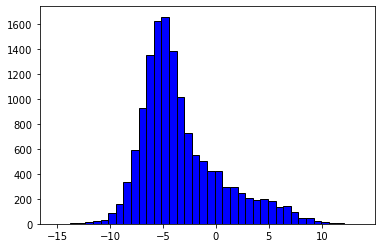

In [20]:
plt.hist(implicit_model.predict(0), color = 'blue', edgecolor = 'black',
         bins = 40)

Not a lot items with high score

### Top-K predictions for a user

The function below (allUsers_topK_implicit) returns a list that contains the top-K recommendations for each user.

In [21]:
import scipy.stats as st
k = 100
def topK_implicit(user, model, k=100):
  a= list()
  ranks = st.rankdata(-model.predict(user))   
  for iid in np.argwhere(ranks <= k):
    #print(iid_rev_map[iid.item(0)])
    a.append(iid_rev_map[iid.item(0)])
  return a

rec_forUser = topK_implicit(0,implicit_model)
print(rec_forUser)

[1237, 1250, 3949, 4308, 4973, 5952, 6016, 6539, 7323, 7327, 8014, 8873, 1907, 3578, 5445, 8368, 8636, 33794, 40815, 2542, 5014, 5225, 5291, 5377, 5956, 5989, 5991, 6863, 6870, 7445, 8783, 8874, 8983, 27660, 27773, 30707, 40819, 44191, 48385, 48394, 48516, 48780, 49530, 51255, 53972, 54503, 55820, 56782, 69122, 69481, 71535, 72998, 73017, 76251, 79132, 97921, 99114, 106782, 109374, 164179, 2951, 5618, 38038, 68954, 72226, 1947, 3435, 5577, 6942, 8638, 30810, 41285, 44555, 69757, 3000, 3752, 8784, 8950, 27904, 63082, 94959, 5995, 31658, 2313, 3462, 7099, 1464, 5902, 86882, 1209, 4873, 6807, 7981, 2076, 1227, 5791, 3424, 3910, 34542, 51540]


In [22]:
def allUsers_topK_implicit(model):
    a = []
    for i in range(len(num_users)):
       a.append(topK_implicit(i,model))
    return a

In [23]:
movies_df.loc[movies_df['movieId'].isin(rec_forUser)]

,movieId,title,genres


In [24]:
movies_pred = movies_df['movieId'][movies_df['movieId'].isin(rec_forUser)]

### Μovies watched from a user

In [25]:
actual = ratings_df[ratings_df["userId"]==uid_rev_map.get(0)].groupby("movieId")["movieId"].count().sort_values(ascending=False).head(100)

In [26]:
actual = actual.index.tolist()

In [27]:
movies_df.loc[movies_df['movieId'].isin(actual)]

,movieId,title,genres
292,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
302,306,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
303,307,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama


In [28]:
movies_watched = movies_df['movieId'][movies_df['movieId'].isin(actual)]

### NDCG Score

In [29]:
allUsers_topK_imp = allUsers_topK_implicit(implicit_model)

In [30]:
rec_forUser == allUsers_topK_imp[0]

True

In [31]:
relevance_implicit = []
for i in range(len(rec_forUser)):
    if rec_forUser[i] in test_df['movie_id'][test_df['user_id'] == 1].values.tolist():
        relevance_implicit.append(1)
    else:
        relevance_implicit.append(0)
    

Compute the relevance for each user. The relevance containes 0s and 1s based on which movies each has watched. For every recommended movie that the user has actually watched, the value of 1 is assigned. There is a relevance list for each user.

In [32]:
def relevance_spotlight_implicit(allUsers_topK):
    relevance_implicit_full = []
    helper = []
    count = 0
    for i in range(1,len(num_users)+1):
        for j in range(len(allUsers_topK[count])):
            if allUsers_topK[count][j] in test_df['movie_id'][test_df['user_id'] == i].values.tolist():
                helper.append(1)
            else:
                helper.append(0)
        relevance_implicit_full.append(helper)
        helper = []
        count += 1
    return relevance_implicit_full

In [33]:
relevance_implicit_full = relevance_spotlight_implicit(allUsers_topK_imp)

In [34]:
relevance_implicit == relevance_implicit_full[0]

True

The dcg and ideal_dcg functions are taken form https://github.com/lezzago/LambdaMart/blob/master/lambdamart.py. They are necessary to compute the desired NDCG evaluation metric.

In [35]:
def dcg(scores):
    """
    Returns the DCG value of the list of scores.
    Parameters
    ----------
    scores : list
        Contains labels in a certain ranked order

    Returns
    -------
    DCG_val: int
        This is the value of the DCG on the given scores
    """
    return np.sum([
                    (np.power(2, scores[i]) - 1) / np.log2(i + 2)
                    for i in range(len(scores))
                ])

In [36]:
def ideal_dcg(scores):
    """
    Returns the Ideal DCG value of the list of scores.
    Parameters
    ----------
    scores : list
        Contains labels in a certain ranked order

    Returns
    -------
    Ideal_DCG_val: int
        This is the value of the Ideal DCG on the given scores
    """
    scores = [score for score in sorted(scores)[::-1]]
    return dcg(scores)

In [37]:
def NDCG_forUser(relevance):
    return dcg(relevance) / ideal_dcg(relevance)

In [38]:
ndcg = NDCG_forUser(relevance_implicit_full[0])
print(ndcg)
ndcg = NDCG_forUser(relevance_implicit)
print(ndcg)

0.27023815442731974
0.27023815442731974


Creation of a list (allUsers_implicit_ndcg) that contains the NDCG score for each user.

In [39]:
def allUsers_ndcg(relevance):
    allUsers_implicit_ndcg = []
    for i in range(len(num_users)):
        allUsers_implicit_ndcg.append(NDCG_forUser(relevance[i]))
    return allUsers_implicit_ndcg

In [40]:
allUsers_implicit_ndcg = allUsers_ndcg(relevance_implicit_full)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


Fill the nan values with 0s.

In [41]:
allUsers_implicit_ndcg = pd.Series(allUsers_implicit_ndcg).fillna(0).tolist()

## Implicit Sequence model

In [42]:
from spotlight.sequence.implicit import ImplicitSequenceModel
from spotlight.evaluation import sequence_mrr_score
from spotlight.sequence.implicit import ImplicitSequenceModel

### Train Implicit Sequence model

In [43]:
'''sequence_model  = ImplicitSequenceModel(n_iter = 5)

current = time.time()
sequence_model.fit(interactions = implicit_train.to_sequence(),verbose = True)

end = time.time()
diff = end - current
print('Training took %d second'%(diff))'''

"sequence_model  = ImplicitSequenceModel(n_iter = 5)\n\ncurrent = time.time()\nsequence_model.fit(interactions = implicit_train.to_sequence(),verbose = True)\n\nend = time.time()\ndiff = end - current\nprint('Training took %d second'%(diff))"

In [44]:
#sequence_model.predict(sequences = 9724)

### MRR Score

In [45]:
#print(sequence_mrr_score(sequence_model, implicit_test.to_sequence()).mean())

### Top-K predictions for a user

In [46]:
#allUsers_topK_sequence = allUsers_topK_implicit(sequence_model)

### NDCG Score

In [47]:
#relevance_sequence_full = relevance_spotlight_implicit(allUsers_topK_sequence)

In [48]:
#allUsers_sequence_ndcg = allUsers_ndcg(relevance_sequence_full)

In [49]:
#allUsers_sequence_ndcg = pd.Series(allUsers_sequence_ndcg).fillna(0).tolist()

# SVD

Pivot is used to have a matrix that has as rows the userIDs and as columns the movieIDs. The unrated, by a user, movies are assigned the value 0 instead of null. Pivot organizes a DataFrame by giving index and column values. It is helpful in the recommender systems approach.

In [50]:
df_movie_features = train_df.pivot(
    index='user_id',
    columns='movie_id',
    values='rating'
).fillna(0)

In [51]:
df_movie_features

movie_id,1,2,3,4,5,6,7,8,9,10,...,205413,205499,205557,205945,205967,206293,206499,206523,207309,208793
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1748,4.5,3.0,0.0,0.0,0.0,0.0,3.5,0.0,1.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## SVD implementation

In [52]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(df_movie_features, k = 10)

## Predictions

To get the prediction of a rating of an item dj, we can calculate the dot product of the two vectors.
The sigma variable has just the values, so I have to convert to a diagonal matrix in orded to implement the matrix multiplication.

In [53]:
sigma = np.diag(sigma)
svd_predictions_score = np.dot(np.dot(U, sigma), Vt)
svd_predictions_score_df = pd.DataFrame(svd_predictions_score, columns = df_movie_features.columns)


In [54]:
svd_predictions_score[1]

array([ 2.18173211,  0.64939929,  0.25801314, ...,  0.00424608,
       -0.00255027, -0.07405019])

In [55]:
svd_predictions_score_df

movie_id,1,2,3,4,5,6,7,8,9,10,...,205413,205499,205557,205945,205967,206293,206499,206523,207309,208793
0,0.055504,0.016815,-0.029535,-0.004938,-0.052431,-0.051610,-0.033102,-0.001193,-0.061028,-0.039329,...,0.000144,0.000192,0.000216,0.001431,-0.009998,0.000787,0.015328,0.002044,-0.001848,-0.001570
1,2.181732,0.649399,0.258013,0.021586,0.147485,-0.161301,0.408790,0.093728,0.088748,0.686187,...,0.034207,0.045610,0.051311,0.000851,-0.028321,0.009988,-0.005768,0.004246,-0.002550,-0.074050
2,2.383179,0.741897,-0.156974,-0.048234,-0.091223,0.926746,-0.303005,-0.065840,0.116273,0.234714,...,0.021404,0.028539,0.032106,0.001954,0.060172,0.026533,0.037199,0.027431,0.025871,0.118327
3,1.911626,0.430689,-0.091348,-0.015513,0.020192,0.210604,-0.162494,-0.034819,-0.024315,0.131492,...,0.030736,0.040981,0.046103,0.001658,0.024428,0.016602,0.016795,0.012749,0.013661,0.048582
4,1.014890,0.505006,0.302109,0.037663,0.301605,0.414485,0.306052,0.055722,0.164157,0.796647,...,0.000541,0.000722,0.000812,0.000370,-0.005805,0.000530,-0.001460,-0.001584,-0.000674,-0.000287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746,0.363436,0.021293,0.044280,0.019148,0.106280,0.312187,0.205691,0.009294,0.025386,0.193681,...,-0.016710,-0.022280,-0.025065,-0.001175,-0.007125,-0.005826,0.003366,0.000804,0.006783,-0.011238
1747,2.708563,0.841211,0.807753,0.141648,1.278780,2.910992,4.109196,0.710770,1.587697,1.152206,...,0.057246,0.076328,0.085869,-0.020721,0.046955,0.016386,0.108769,0.016384,0.044083,-0.083005
1748,1.256961,0.345806,0.277082,0.034393,0.202350,0.201600,0.426464,0.064461,0.122144,0.360267,...,0.029381,0.039174,0.044071,-0.000259,0.003071,0.002251,-0.002948,-0.003028,-0.002585,-0.021245
1749,0.151613,0.036230,0.018439,0.004433,0.021309,0.002952,0.055459,0.007727,-0.013917,0.006005,...,0.003841,0.005122,0.005762,0.000524,-0.003440,0.000635,-0.000962,0.000501,-0.000531,0.003748


In [56]:
svd_predictions_score_df[svd_predictions_score_df.index == 609]

movie_id,1,2,3,4,5,6,7,8,9,10,...,205413,205499,205557,205945,205967,206293,206499,206523,207309,208793
609,0.772778,0.073804,-0.052349,-0.013713,-0.131644,0.22643,-0.138559,-0.044984,-0.109407,0.113775,...,-0.010922,-0.014563,-0.016383,0.001007,0.001209,-0.001505,0.014195,0.006293,0.005309,-0.00404


## Top-K recommendations

### First

The function below returns a list that contains the top-100 recommendations for each user

In [57]:
def SVD_topK_first(score_df):
    topK_svd_rec = []
    for i in range(len(num_users)):
        svd_h_df = pd.DataFrame({'movie_id': score_df[score_df.index == i].columns,
                                 'score': score_df[score_df.index == i].values[0]})
        svd_h_df = svd_h_df.sort_values('score', ascending=False)
        svd_h_df = svd_h_df.head(100)
        topK_svd_rec.append(svd_h_df['movie_id'].values)
    return topK_svd_rec

#### NDCG Score

The function below returns the relevance list of a list of movies.

In [58]:
def SVD_relevance_first(score_df):
    svd_topK = SVD_topK_first(score_df)
    relevance_svd_full = []
    helper = []
    count = 0
    for i in range(1,len(num_users)+1):
        for j in range(len(svd_topK[count])):
            if svd_topK[count][j] in test_df['movie_id'][test_df['user_id'] == i].values.tolist():
                helper.append(1)
            else:
                helper.append(0)
        relevance_svd_full.append(helper)
        helper = []
        count += 1
    return relevance_svd_full

In [59]:
relevance_first = SVD_relevance_first(svd_predictions_score_df)

In [60]:
np.asarray(relevance_first).shape

(1751, 100)

In [61]:
n_f = NDCG_forUser(relevance_first[0])

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [62]:
n_f

nan

Below is the NDCG scores of each user

In [63]:
all_ndcg_f = allUsers_ndcg(relevance_first)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [64]:
all_ndcg_f = pd.Series(all_ndcg_f).fillna(0).tolist()

In [65]:
np.asarray(all_ndcg_f).mean()

0.40635414589238517

### Second

Code used from https://github.com/nikitaa30/Recommender-Systems/blob/master/matrix_factorisation_svd.py

Provide top-K predictions for a user

In [66]:
'''def recommend_movies(preds_df, userID, movies_df, original_ratings_df, num_recommendations):
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.userId == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])]).merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left', left_on = 'movieId',
               right_on = 'movie_id').rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :-1]
                      

    return user_full, recommendations'''

"def recommend_movies(preds_df, userID, movies_df, original_ratings_df, num_recommendations):\n    # Get and sort the user's predictions\n    user_row_number = userID - 1 # UserID starts at 1, not 0\n    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1\n    \n    # Get the user's data and merge in the movie information.\n    user_data = original_ratings_df[original_ratings_df.userId == (userID)]\n    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').\n                     sort_values(['rating'], ascending=False)\n                 )\n    # Recommend the highest predicted rating movies that the user hasn't seen yet.\n    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])]).merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left', left_on = 'movieId',\n               right_on = 'movie_id').rename(columns = {user_row_number: 'Predictions'}).sort

In [67]:
'''already_rated, predictions = recommend_movies(svd_predictions_score_df, 1, movies_df, ratings_df, 100)
predictions.head()'''

'already_rated, predictions = recommend_movies(svd_predictions_score_df, 1, movies_df, ratings_df, 100)\npredictions.head()'

The function SVD_topK_allUsers returens a list that contains the top-K recommendations for each user.

In [68]:
'''def SVD_topK_allUsers():
    allUsers_already_rated = []
    allUsers_predictions = []
    for i in range(1,len(num_users)+1):
        already_rated, predictions = recommend_movies(svd_predictions_score_df, i, movies_df, ratings_df, 100)
        allUsers_already_rated.append(already_rated)
        allUsers_predictions.append(predictions)
    return allUsers_predictions'''

'def SVD_topK_allUsers():\n    allUsers_already_rated = []\n    allUsers_predictions = []\n    for i in range(1,len(num_users)+1):\n        already_rated, predictions = recommend_movies(svd_predictions_score_df, i, movies_df, ratings_df, 100)\n        allUsers_already_rated.append(already_rated)\n        allUsers_predictions.append(predictions)\n    return allUsers_predictions'

#### NDCG Score

The function SVD_relevance returns a list that contains the relevance (0s and 1s) between the top-K recommendations and the movies that each user actually watched.

In [69]:
'''def SVD_relevance():
    svd_topK = SVD_topK_allUsers()
    relevance_svd_full = []
    helper = []
    count = 0
    for i in range(1,len(num_users)+1):
        for j in range(len(svd_topK[count])):
            if svd_topK[count]['movieId'].values[j] in test_df['movie_id'][test_df['user_id'] == i].values.tolist():
                helper.append(1)
            else:
                helper.append(0)
        relevance_svd_full.append(helper)
        helper = []
        count += 1
    return relevance_svd_full'''

"def SVD_relevance():\n    svd_topK = SVD_topK_allUsers()\n    relevance_svd_full = []\n    helper = []\n    count = 0\n    for i in range(1,len(num_users)+1):\n        for j in range(len(svd_topK[count])):\n            if svd_topK[count]['movieId'].values[j] in test_df['movie_id'][test_df['user_id'] == i].values.tolist():\n                helper.append(1)\n            else:\n                helper.append(0)\n        relevance_svd_full.append(helper)\n        helper = []\n        count += 1\n    return relevance_svd_full"

In [70]:
#svd_relevance = SVD_relevance()

In [71]:
#allUsers_svd_ndcg = allUsers_ndcg(svd_relevance)

# LightGBM Baseline

I create 2 features, which are the scores from the Implicit and SVD models on the top-K recommendations for each user based on the implicit model.

In [72]:
#target_movies = allUsers_topK_imp
#for i in range(len(num_users)):
#    target_movies.append(topK_implicit(i,implicit_model))

##  Feature 1 (Implicit factorization model scores)

Train an implicit factorization model using the train_features dataset

In [73]:
f1_model = ImplicitFactorizationModel(n_iter = 5)

current = time.time()

f1_model.fit(implicit_train_features,verbose = True)

end = time.time()
diff = end - current
print('Training took %d second'%(diff))

Epoch 0: loss 0.5977691603302956
Epoch 1: loss 0.34763483357429503
Epoch 2: loss 0.3158217426538467
Epoch 3: loss 0.28201976531744005
Epoch 4: loss 0.25089010363817216
Training took 118 second


In [74]:
allUsers_topK_f1 = allUsers_topK_implicit(f1_model)
target_movies = allUsers_topK_f1

Map the target movies to pick the correct predictions based on the item id

In [75]:
def map_movies(target_movies):
    map_target_movies = []
    map_help = []
    for movies in target_movies:
        for movie in movies:
            map_help.append(iid_map[movie])
        map_target_movies.append(map_help)
        map_help = []
    return map_target_movies

Implicit Factorization model Scores

Train implicit on implicit_features_train! and take these scores.

In [76]:
def give_movies_implicit_scores(map_movies):
    implicit_scores = 0
    feature = []
    for i in range(len(num_users)):
        #for movies in map_target_movies:
        my_list = map_movies[i]
        my_array = np.array(my_list)
        implicit_scores = f1_model.predict(user_ids = i,item_ids = my_array)
        feature.append(implicit_scores)
    return feature

In [77]:
map_target_movies = map_movies(target_movies)
feature1 = give_movies_implicit_scores(map_target_movies)
feature1 = np.asarray(feature1)
feature1.shape

(1751, 100)

In [78]:
#feature1 = np.asarray(feature1).reshape(len(num_users),100)

## Feature 2 (Implicit sequence model scores)

In [79]:
'''f2_model = ImplicitSequenceModel(n_iter = 5)

current = time.time()

f2_model.fit(implicit_train_features.to_sequence(),verbose = True)

end = time.time()
diff = end - current
print('Training took %d second'%(diff))'''

"f2_model = ImplicitSequenceModel(n_iter = 5)\n\ncurrent = time.time()\n\nf2_model.fit(implicit_train_features.to_sequence(),verbose = True)\n\nend = time.time()\ndiff = end - current\nprint('Training took %d second'%(diff))"

In [80]:
'''implicit_scores = 0
feature2 = []
for i in range(len(num_users)):
    #for movies in map_target_movies:
    my_list = map_target_movies[i]
    my_array = np.array(my_list)
    implicit_scores = f2_model.predict(i,item_ids = my_array)
    feature2.append(implicit_scores)'''

'implicit_scores = 0\nfeature2 = []\nfor i in range(len(num_users)):\n    #for movies in map_target_movies:\n    my_list = map_target_movies[i]\n    my_array = np.array(my_list)\n    implicit_scores = f2_model.predict(i,item_ids = my_array)\n    feature2.append(implicit_scores)'

## Feature 3 (SVD scores)

SVD model Scores. Take advantage of the DataFrame containing the scores to extract the predicted scores for the desired movies.

In [81]:
df_movie_features1 = train_features_df.pivot(
    index='user_id',
    columns='movie_id',
    values='rating'
).fillna(0)

In [82]:
U1, sigma1, Vt1 = svds(df_movie_features1)
sigma1 = np.diag(sigma1)
svd_predictions_score1 = np.dot(np.dot(U1, sigma1), Vt1)
svd_predictions_score_df1 = pd.DataFrame(svd_predictions_score1, columns = df_movie_features1.columns)

In [83]:
target_movies[0][2]

6016

In [84]:
svd_predictions_score_df1[svd_predictions_score_df1.index == 0]

movie_id,1,2,3,4,5,6,7,8,9,10,...,205383,205413,205499,205945,205967,206293,206499,206523,207309,208793
0,0.05852,-0.02963,-0.036151,-0.002254,-0.030975,0.084782,-0.032484,-0.016548,-0.030549,-0.051453,...,0.00165,-0.003279,-0.004372,0.000233,0.002074,-0.000883,0.009211,0.001653,0.002372,0.005047


In [85]:
float(svd_predictions_score_df1[svd_predictions_score_df1.index == 0][target_movies[0][0]].values)

0.3034030128790671

In [86]:
feature3 = []
feature3_user = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        feature3_user.append(float(svd_predictions_score_df1[svd_predictions_score_df1.index == i][target_movies[i][j]].values))
    feature3.append(feature3_user)
    feature3_user = []

In [87]:
type(feature3)

list

## Feature 4 (Genre)

In [127]:
def create_genre_feature(genre):
    feature = []
    genre_per_user = []
    for i in range(len(num_users)):
        for j in range(len(target_movies[i])):
            a =  movies_df[movies_df['movieId'] == target_movies[i][j]]['genres']
            a = a.tolist()
            a = str(a[0])
            a = a.split('|')
            if genre in a:
                genre_per_user.append(1)
            else:
                genre_per_user.append(0)
        feature.append(genre_per_user)
        genre_per_user = []
    return feature

In [128]:
feature4 = create_genre_feature('Comedy')

### Features 8-15 (genres)

In [129]:
feature8 = create_genre_feature('Adventure')
feature9 = create_genre_feature('Drama')
feature10 = create_genre_feature('Romance')
feature11 = create_genre_feature('Fantasy')
feature12 = create_genre_feature('Thriller')
feature13 = create_genre_feature('Animation')
feature14 = create_genre_feature('Children')
feature15 = create_genre_feature('Horror')

## Feature 5 (#Users watched each target movie)

In [130]:
number_views = []
number_view_per_movie = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        a = len(ratings_df[ratings_df['movieId'] == target_movies[i][j]]['userId'])
        number_view_per_movie.append(a)
    number_views.append(number_view_per_movie)
    number_view_per_movie = []


In [131]:
feature5 = number_views

## Feature 6 (New user)

In [166]:
len(ratings_df[ratings_df['userId']==1]) > 10

True

In [133]:
new_users_binary = []
binary_per_user = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        a = len(ratings_df[ratings_df['userId']==1]) > 10
        if a:
            binary_per_user.append(1)
        else:
            binary_per_user.append(0)
    new_users_binary.append(binary_per_user)
    binary_per_user = []

In [134]:
feature6 = new_users_binary

## Feature 7 (Negative samples)

In [135]:
import random
target_negative = []
for i in range(1,len(num_users)+1):
    target_negative.append(random.choices(train_features_df[train_features_df['user_id']==i]['movie_id'].values, k = 100))

In [136]:
map_negative_movies = map_movies(target_negative)
feature7 = give_movies_implicit_scores(map_negative_movies)
feature7 = np.asarray(feature7)
feature7.shape

(1751, 100)

## Features stack

In [137]:
features = np.stack((feature1,feature3,feature4,feature5,feature8,feature9,feature10,feature11,feature12,
                    feature13,feature14,feature15))

## Labels

Below are the movies that each user watched

In [138]:
def watched_movies(df):
    watched = []
    for i in range(len(num_users)):
        watched.append(df[df["user_id"]==uid_rev_map.get(i)].groupby("movie_id")["movie_id"].count().index)  
    return watched

In [139]:
#train_labels_df
#test_df
#val_df
train_watched = watched_movies(train_labels_df)
test_watched = watched_movies(test_df)
val_watched = watched_movies(val_df)

Creation of the target list. It containes 0s and 1s for the 100 recommended movies for each user. Based on the watched movies it assigns the values. If the user watched the recommended movie, then the value of the target is equal to 1, otherwise it is 0.

In [140]:
def create_target(watched):
    user_target = []
    target = []
    for i in range(len(num_users)):
        for target_movie in target_movies[i]:
            if target_movie in watched[i]:
                user_target.append(1)
            else:
                user_target.append(0)
        target.append(user_target)
        user_target = []
    return target

In [141]:
label_train = create_target(train_watched)
label_test = create_target(test_watched)
label_val = create_target(val_watched)
#y_train = y_test = y_val

## LightGBM model

In [142]:
X = np.array(features)
label_train = np.array(label_train)
label_test = np.array(label_test)
label_val = np.array(label_val)

In [143]:
X = X.reshape(len(num_users)*k, len(features))
y_train = label_train.reshape(len(num_users)*k,)
y_test = label_test.reshape(len(num_users)*k,)
y_val = label_val.reshape(len(num_users)*k,)

In [144]:
import lightgbm as lgb
gbm = lgb.LGBMRanker(min_child_samples=1, learning_rate=.1, n_jobs=2, importance_type='gain',
                     num_leaves=31, min_child_weight=100)

target movies
train_df
feature1
feature2

In [145]:
'''X_train_feature1 = []
X_train_feature2 = []
for j in range(610):
    for i in range(len(target_movies[j])):
        if target_movies[j][i] in val_df['movie_id'].values.tolist():
            X_train_feature1.append(feature1[i])
            X_train_feature2.append(feature2[i])
print(X_train_feature1)
print(X_train_feature2)
#X_train = np.stack(X_train_feature1,X_train_feature2)'''

"X_train_feature1 = []\nX_train_feature2 = []\nfor j in range(610):\n    for i in range(len(target_movies[j])):\n        if target_movies[j][i] in val_df['movie_id'].values.tolist():\n            X_train_feature1.append(feature1[i])\n            X_train_feature2.append(feature2[i])\nprint(X_train_feature1)\nprint(X_train_feature2)\n#X_train = np.stack(X_train_feature1,X_train_feature2)"

X_train
X_test
X_val
y_train
y_test
y_val

In [146]:
X_train = X
X_test = X
X_val = X

In [147]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [148]:
query_train = [X_train.shape[0]]
query_val = [X_val.shape[0]]
query_test = [X_test.shape[0]]
group_train = []
group_val = []
print(query_train)
print(query_val)
print(query_test)
'''
for i in range(390):
    group_train.append(100)
group_train.append(40)
group_val.append(60)
for i in range(97):
    group_val.append(100)'''

for i in range(len(num_users)):
    group_train.append(k)
    group_val.append(k)


[175100]
[175100]
[175100]


In [149]:
gbm.fit(X_train, y_train, group=group_train,
        eval_set=[(X_val, y_val)], eval_group=[group_val],
        eval_at=[1, 3, 5, 10], early_stopping_rounds=50, eval_metric='ndcg')

[1]	valid_0's ndcg@1: 0.199315	valid_0's ndcg@3: 0.198129	valid_0's ndcg@5: 0.202491	valid_0's ndcg@10: 0.220352
Training until validation scores don't improve for 50 rounds
[2]	valid_0's ndcg@1: 0.190748	valid_0's ndcg@3: 0.190855	valid_0's ndcg@5: 0.195365	valid_0's ndcg@10: 0.211285
[3]	valid_0's ndcg@1: 0.192461	valid_0's ndcg@3: 0.192505	valid_0's ndcg@5: 0.196142	valid_0's ndcg@10: 0.212436
[4]	valid_0's ndcg@1: 0.195317	valid_0's ndcg@3: 0.191599	valid_0's ndcg@5: 0.194248	valid_0's ndcg@10: 0.211688
[5]	valid_0's ndcg@1: 0.189035	valid_0's ndcg@3: 0.190809	valid_0's ndcg@5: 0.195024	valid_0's ndcg@10: 0.209627
[6]	valid_0's ndcg@1: 0.193604	valid_0's ndcg@3: 0.193042	valid_0's ndcg@5: 0.196528	valid_0's ndcg@10: 0.211923
[7]	valid_0's ndcg@1: 0.191319	valid_0's ndcg@3: 0.190932	valid_0's ndcg@5: 0.194044	valid_0's ndcg@10: 0.210142
[8]	valid_0's ndcg@1: 0.182182	valid_0's ndcg@3: 0.187111	valid_0's ndcg@5: 0.192634	valid_0's ndcg@10: 0.206607
[9]	valid_0's ndcg@1: 0.179897	vali

LGBMRanker(importance_type='gain', min_child_samples=1, min_child_weight=100,
           n_jobs=2)

In [150]:
test_pred = gbm.predict(X_test)
test_pred

array([0.00109765, 0.00109765, 0.00109765, ..., 0.00486492, 0.00486492,
       0.00486492])

## NDCG Score

In [151]:
p = 0
m = 100
lgbm_pred_per_user = []
for i in range(len(num_users)):
    lgbm_pred_per_user.append(test_pred[p:m])
    p += 100
    m += 100

### NDCG IFM on this data

In [152]:
feature8 = create_genre_feature('Adventure')
feature9 = create_genre_feature('Drama')
feature10 = create_genre_feature('Romance')
feature11 = create_genre_feature('Fantasy')
feature12 = create_genre_feature('Thriller')
feature13 = create_genre_feature('Animation')
feature14 = create_genre_feature('Children')
feature15 = create_genre_feature('Horror')
lgbm_NDCG = []
IFM_NDCG = []
SVD_NDCG = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'model1_score': feature1[i], 'model2_score': feature3[i],
                             'is_comedy': feature4[i], 'is_adventure': feature8[i], 'is_drama': feature9[i], 
                             'is_romance': feature10[i], 'is_fantasy': feature11[i], 'is_thriller': feature12[i], 
                             'is_animation': feature13[i], 'is_children': feature14[i], 'is_horror': feature15[i], 
                             '#users_watched': feature5[i], 
                             'train_label': label_train[i], 'test_label': label_test[i],
                             'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
    excel_df = excel_df.sort_values('model1_score', ascending=False)
    ifm_relevance = excel_df['test_label'].values.tolist()
    IFM_NDCG.append(NDCG_forUser(ifm_relevance))
    excel_df = excel_df.sort_values('model2_score', ascending=False)
    svd_relevance_h = excel_df['test_label'].values.tolist()
    SVD_NDCG.append(NDCG_forUser(svd_relevance_h))

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [153]:
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
IFM_NDCG = pd.Series(IFM_NDCG).fillna(0).tolist()
SVD_NDCG = pd.Series(SVD_NDCG).fillna(0).tolist()

## Excel-Like

In [154]:
excel1_df = pd.DataFrame({'movie_id': target_movies[0],'model1_score':feature1[0], 'model2_score':feature3[0],'is_comedy':feature4[0],
                            '#users_watched':feature5[0], 'train_label':label_train[0], 'test_label':label_test[0],
                            'label_val':label_val[0],'LGBM Score':lgbm_pred_per_user[0]})

In [155]:
excel1_df.head(10)

,movie_id,model1_score,model2_score,is_comedy,#users_watched,train_label,test_label,label_val,LGBM Score
0,4973,9.736027,0.303403,1,345,0,0,0,0.001098
1,5952,9.221828,0.247494,0,508,0,0,0,0.001098
2,6016,12.686938,0.212600,0,193,0,0,1,0.001098
3,7323,10.843340,0.049903,1,53,0,0,0,0.001098
4,8014,10.816641,0.030031,0,26,0,0,0,0.001098
5,8360,10.140123,0.062568,1,191,1,0,0,0.001098
6,27266,12.945586,0.039136,0,12,0,0,0,0.001098
7,356,9.279446,0.153832,1,872,0,0,0,0.001098
8,589,8.759470,0.018919,0,607,0,0,0,-0.022442
9,1291,8.918200,0.063964,0,395,0,0,0,-0.022442


In [156]:
excel1_df = excel1_df.sort_values('LGBM Score',ascending = False)
excel1_df.head(10)

,movie_id,model1_score,model2_score,is_comedy,#users_watched,train_label,test_label,label_val,LGBM Score
0,4973,9.736027,0.303403,1,345,0,0,0,0.001098
1,5952,9.221828,0.247494,0,508,0,0,0,0.001098
36,54997,9.077278,0.052630,0,46,0,0,0,0.001098
37,55820,9.414132,0.173037,0,174,0,0,0,0.001098
38,56174,11.009188,0.054282,0,110,0,0,0,0.001098
39,56782,8.783957,0.126817,0,96,0,0,0,0.001098
40,59369,10.180099,0.055390,0,113,0,0,0,0.001098
41,60069,11.222290,0.149589,0,279,0,0,0,0.001098
42,60684,9.446898,0.082922,0,126,0,0,0,0.001098
43,60756,11.016588,0.032559,1,37,0,0,0,0.001098


In [157]:
relevance_lgbm_firstUser = excel1_df['test_label'].values.tolist()

In [158]:
L1GBM_ndcg = NDCG_forUser(relevance_lgbm_firstUser)
L1GBM_ndcg

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


nan

## NDCG Comparison

In [159]:
allUsers_implicit_ndcg[0]

0.27023815442731974

In [160]:
ndcg_df = pd.DataFrame({'Implicit FM': allUsers_implicit_ndcg, 'LightGBM': lgbm_NDCG, 'IFM_this': IFM_NDCG,
                        'SVD_this': SVD_NDCG})

In [161]:
ndcg_df

,Implicit FM,LightGBM,IFM_this,SVD_this
0,0.270238,0.000000,0.000000,0.000000
1,0.451599,0.337722,0.415606,0.625604
2,0.515270,0.455025,0.452480,0.462177
3,0.494561,0.309827,0.263460,0.352267
4,0.517132,0.382430,0.427002,0.509471
...,...,...,...,...
1746,0.000000,0.000000,0.000000,0.000000
1747,0.568820,0.606279,0.620407,0.688785
1748,0.000000,0.464440,0.276567,0.566484
1749,0.000000,0.000000,0.000000,0.000000


In [162]:
ndcg_df['Implicit FM'].mean()

0.33797626506036577

In [167]:
lgbm_mean = ndcg_df['LightGBM'].mean()

In [168]:
ifm_mean = ndcg_df['IFM_this'].mean()

In [169]:
svd_mean = ndcg_df['SVD_this'].mean()

## Visualization

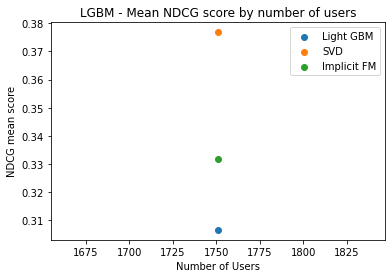

In [189]:
plt.scatter(len(num_users),lgbm_mean,label = 'Light GBM')
plt.scatter(len(num_users),svd_mean, label = 'SVD')
plt.scatter(len(num_users),ifm_mean, label = 'Implicit FM')
plt.xlabel('Number of Users')
plt.ylabel('NDCG mean score')
plt.title('LGBM - Mean NDCG score by number of users')
plt.legend()

## Save comparison

In [190]:
#ndcg_df.to_pickle("./ndcg_f1-15_minus67_250k.pkl")


Feature ideas
1. Rank (rankdata from recsys project, array-n -> returns array-n containing results ->1,2,3 -> 1 is the best)
2. Negative samples (random-k) (now I train it only on high relevance)
3. Feature importances (plot)

# Draft

In [ ]:
from sklearn.metrics import dcg_score
true = np.asarray([actual])
pred = np.asarray([predicted_rank_svd])
dcg = dcg_score(true,pred)
idcg = dcg_score(true,true)
ndcg = dcg/idcg

In [ ]:
ndcg

In [ ]:
from sklearn.metrics import ndcg_score
n = ndcg_score(true,pred)
n

In [ ]:
'''relevance = []
for i in range(20,40):
    if predicted_rank_svd[i] in actual:
        relevance.append(1)
    else:
        relevance.append(0)'''

In [ ]:
svd_rank_allUsers = []
for i in range(1,len(num_users)+1):
    already_rated, predictions = recommend_movies(svd_predictions_score_df, i, movies_df, ratings_df, 100)
    svd_rank_allUsers.append(predictions['movieId'].index.tolist()) 


In [ ]:
'''def NDCG_forUser_SVD(user):
    return dcg(svd_predictions[svd_predictions_df.index == user]) / ideal_dcg(svd_predictions[svd_predictions_df.index == user])'''

In [ ]:
'''NDCG_SVD = NDCG_forUser_SVD(2)'''

In [ ]:
'''NDCG_SVD'''

Take as features the predicted ratings for the users of SVD and Implicit for the next step?

## Embeddings 

In [ ]:
emb = implicit_model._net.item_embeddings

In [ ]:
a = emb.weight.data[0].numpy()

In [ ]:
a

## KNN

Pivot is used to have a matrix that has as rows the userIDs and as columns the movieIDs. The unrated, by a user, movies are assigned the value 0 instead of null. Pivot organizes a DataFrame by giving index and column values. It is helpful in the recommender systems approach.

In [ ]:
df_movie_features = ratings_df.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

In [ ]:
df_movie_features

In [ ]:
height = [len(df_movie_features.values[df_movie_features.values== 0]),len(df_movie_features.values[df_movie_features.values==0.5]),
          len(df_movie_features.values[df_movie_features.values== 1]),len(df_movie_features.values[df_movie_features.values==1.5]),
          len(df_movie_features.values[df_movie_features.values== 2]),len(df_movie_features.values[df_movie_features.values==2.5]),
          len(df_movie_features.values[df_movie_features.values== 3]),len(df_movie_features.values[df_movie_features.values==3.5]),
          len(df_movie_features.values[df_movie_features.values== 4]),len(df_movie_features.values[df_movie_features.values==4.5]),
          len(df_movie_features.values[df_movie_features.values== 5])]
x = ('0','0.5', '1','1.5' ,'2','2.5', '3','3.5', '4','4.5','5')
plt.bar(x, height)
plt.xlabel('Rating')
plt.ylabel('Number of users')
plt.show()


A lot of ratings in the user-movie matrix are zero, so the data are extremely sparse.

To makes sesne the idea of obtaining the taste of the users, they should have rated at least 20 movies. Otherwise, the taste of them is not clear. The users that have rated less than 20 movies will be excluded. Also the movies that have less than 20 ratings will be excluded too.

In [ ]:
popularity_thres = 20
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)
# filter data to come to an approximation of user likings.
ratings_thres = 20
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(ratings_df)

In [ ]:
ratings_df[24400:24450]

In [ ]:
excel_df